#**Bidirectional GRU model training and testing**



###Drive preparation section

Mounting google drive to access data on drive.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Assigning variables to file path

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'Data', 'Writeups']


In [ ]:
DATA_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation/Data' 
DATA_PATH = os.path.join('drive', 'My Drive', DATA_PATH_AFTER_MYDRIVE)
print(os.listdir(DATA_PATH))

['Bengaluru_air_met_df.csv', 'Delhi_air_met_df.csv', 'Hyderabad_air_met_df.csv', 'Jaipur_air_met_df.csv', 'Mumbai_air_met_df.csv', 'Saved_Models']


###Packages installation section

Installation of tensorflow package for algorithms.

In [ ]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of PerMetrics package for Performance metrics of models

In [ ]:
! pip install permetrics==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of Keras Tuner package for hyperparameter tuning of models.

In [ ]:
! pip install keras-tuner -q

     |████████████████████████████████| 135 kB 7.8 MB/s 
     |████████████████████████████████| 1.6 MB 37.0 MB/s 


Installation of tensorflow addons package for AdamW optimizer.

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 


###Time series data preparation section

Import of necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from math import sqrt
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from permetrics.regression import RegressionMetric
import keras_tuner
import tensorflow_addons as tfa
import time
import pickle

Seed random generators for consistent results over different runs of the code script.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Load data preprocessed data set of air pollution and meteorological data for Delhi city into a pandas dataframe.

In [ ]:
Delhi_air_met_df = pd.read_csv(os.path.join(DATA_PATH,'Delhi_air_met_df.csv'))

Delete unnecessary columns.

In [ ]:
Delhi_air_met_df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

*Coding reference for above executions:*

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Splitting data into train and test sets without shuffeling, to preserve the chronology of the time series data.

In [ ]:
train_size = int(len(Delhi_air_met_df) * 0.8)
test_size = len(Delhi_air_met_df) - train_size
train_df, test_df = Delhi_air_met_df.iloc[0:train_size], Delhi_air_met_df.iloc[train_size:len(Delhi_air_met_df)]

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

Creation of normalization object.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

Fitting only training data to normalization object.

In [ ]:
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

Scaling test data with normalization object that has been trained with training data only.

In [ ]:
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

Defining a function to create Rolling Window of time series data.

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Assigning variable to time period/frame of past timestamps, which the models would take as input to predict target value at future timestamp(S).

In [ ]:
time_steps = 24

Obtraining variables and targets for training and test data sets in Rolling Window format unsing above defined function. 

Note that the variables that will be input for the algorithms will be in 3 dimensional array, with a shape as 

(no. of observations, time steps of past, number of variable).

In [ ]:
X_train, y_train = create_dataset(train_df, train_df['PM2.5'], time_steps)
X_test, y_test = create_dataset(test_df, test_df['PM2.5'], time_steps)

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

###Model trainig, testing and tuning section

Creation of early stopping object to stop trainig after no decrease in loss function value after consecutive number of steps assigned to patience argument.

In [12]:
early_stopping_monitor = EarlyStopping(patience=10)

*Coding reference for above executions:*

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Creation of baseline model.

In [ ]:
BiGRU_model0 = keras.Sequential()
BiGRU_model0.add(layers.Bidirectional(layers.GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model0.add(layers.Dense(1))
BiGRU_model0.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Fitting baseline model to training data.

In [ ]:
BiGRU0_history = BiGRU_model0.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 11s 7ms/step - loss: 0.0493 - val_loss: 0.0166
Epoch 2/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0321 - val_loss: 0.0160
Epoch 3/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0316 - val_loss: 0.0144
Epoch 4/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0312 - val_loss: 0.0134
Epoch 5/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0312 - val_loss: 0.0124
Epoch 6/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0310 - val_loss: 0.0125
Epoch 7/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0308 - val_loss: 0.0111
Epoch 8/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0120
Epoch 9/100
479/479 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0135
Epoch 10/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0304 - val_l

Plotting loss curves of trainig and validation sets during the training of the baseline model.

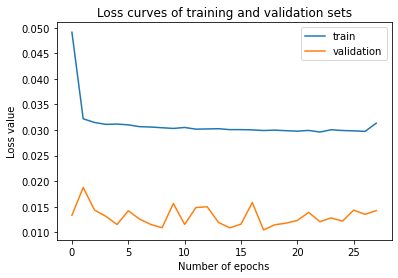

In [ ]:
plt.plot(BiGRU0_history.history['loss'], label='train')
plt.plot(BiGRU0_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Prediction of target values for test data set variables.

In [ ]:
y_pred0 = BiGRU_model0.predict(X_test)

Reshaping the array of actual target values of test data set and then applying inverse transformation to get them to original scale before comparison with prediction values.

In [ ]:
y_test_reshaped = y_test.reshape(-1,1)
y_test_inv = np.concatenate((test_df.values[:-24,:-1], y_test_reshaped), axis=1)
y_test_inv = scaler.inverse_transform(y_test_inv)[:,-1]

Defining a function that would apply inverse transform to the predicted values of target for test data set to make them comparable with the actual values of target in the original scale of the data.

In [ ]:
def prediction_invertor(ypredict):
  ypredict_inverse = np.concatenate((test_df.values[:-24,:-1], ypredict), axis=1)
  ypredict_inverse = scaler.inverse_transform(ypredict_inverse)[:,-1]

  return ypredict_inverse;

Obtaining predicted value of test target column in scale of original data.

In [ ]:
y_pred0_inv = prediction_invertor(y_pred0)

Evaluation of baseline model performance in terms of Root Mean Square Error by comparing the actual and predicted values of target column of test data set.

In [ ]:
rmse0 = metrics.mean_squared_error(y_test_inv, y_pred0_inv, squared=False)
print('Test RMSE: %.3f' % rmse0)

Test RMSE: 23.919


*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Creation of small subsets of training data to fit to models for hyperparameter tuning.

In [ ]:
X_grid, y_grid = X_train[:10000], y_train[:10000]

Creation of small subsets of training data to validate models for hyperparameter tuning.

In [ ]:
X_grid_val, y_grid_val = X_train[10000:12000], y_train[10000:12000]

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model1(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int("units", min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner11 = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner11.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 12 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 53s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner11.get_best_hyperparameters()[0].values

{'units': 200,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner12 = keras_tuner.BayesianOptimization(
    hypermodel=build_model1,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner12.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 11m 13s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner12.get_best_hyperparameters()[0].values

{'units': 200, 'learning_rate': 0.001}

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model11 = keras.Sequential()
BiGRU_model11.add(layers.Bidirectional(layers.GRU(200, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model11.add(layers.Dense(1))
BiGRU_model11.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [ ]:
BiGRU11_history = BiGRU_model11.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 68s 131ms/step - loss: 0.0396 - val_loss: 0.0131
Epoch 2/100
479/479 [==============================] - 58s 121ms/step - loss: 0.0333 - val_loss: 0.0241
Epoch 3/100
479/479 [==============================] - 58s 122ms/step - loss: 0.0326 - val_loss: 0.0128
Epoch 4/100
479/479 [==============================] - 58s 122ms/step - loss: 0.0326 - val_loss: 0.0128
Epoch 5/100
479/479 [==============================] - 58s 122ms/step - loss: 0.0317 - val_loss: 0.0118
Epoch 6/100
479/479 [==============================] - 58s 122ms/step - loss: 0.0321 - val_loss: 0.0161
Epoch 7/100
479/479 [==============================] - 59s 123ms/step - loss: 0.0315 - val_loss: 0.0119
Epoch 8/100
479/479 [==============================] - 58s 122ms/step - loss: 0.0313 - val_loss: 0.0120
Epoch 9/100
479/479 [==============================] - 59s 122ms/step - loss: 0.0312 - val_loss: 0.0126
Epoch 10/100
479/479 [==============================] - 58s 122m

In [ ]:
y_pred11 = BiGRU_model11.predict(X_test)

In [ ]:
y_pred11_inv = prediction_invertor(y_pred11)

In [ ]:
rmse11 = metrics.mean_squared_error(y_test_inv, y_pred11_inv, squared=False)
print('Test RMSE: %.3f' % rmse11)

Test RMSE: 22.142


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model12 = keras.Sequential()
BiGRU_model12.add(layers.Bidirectional(layers.GRU(200, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model12.add(layers.Dense(1))
BiGRU_model12.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiGRU12_history = BiGRU_model12.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 64s 125ms/step - loss: 0.0584 - val_loss: 0.0156
Epoch 2/100
479/479 [==============================] - 61s 127ms/step - loss: 0.0329 - val_loss: 0.0223
Epoch 3/100
479/479 [==============================] - 59s 122ms/step - loss: 0.0320 - val_loss: 0.0121
Epoch 4/100
479/479 [==============================] - 57s 120ms/step - loss: 0.0321 - val_loss: 0.0152
Epoch 5/100
479/479 [==============================] - 57s 119ms/step - loss: 0.0320 - val_loss: 0.0194
Epoch 6/100
479/479 [==============================] - 57s 120ms/step - loss: 0.0320 - val_loss: 0.0174
Epoch 7/100
479/479 [==============================] - 58s 121ms/step - loss: 0.0318 - val_loss: 0.0137
Epoch 8/100
479/479 [==============================] - 58s 121ms/step - loss: 0.0316 - val_loss: 0.0267
Epoch 9/100
479/479 [==============================] - 57s 120ms/step - loss: 0.0315 - val_loss: 0.0120
Epoch 10/100
479/479 [==============================] - 57s 120m

In [ ]:
y_pred12 = BiGRU_model12.predict(X_test)

In [ ]:
y_pred12_inv = prediction_invertor(y_pred12)

In [ ]:
rmse12 = metrics.mean_squared_error(y_test_inv, y_pred12_inv, squared=False)
print('Test RMSE: %.3f' % rmse12)

Test RMSE: 22.812


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model12(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int("units", min_value=80, max_value=120, step=10), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner112 = keras_tuner.Hyperband(
    hypermodel=build_model12,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner112.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 15 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 32s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner112.get_best_hyperparameters()[0].values

{'units': 80,
 'learning_rate': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner122 = keras_tuner.BayesianOptimization(
    hypermodel=build_model12,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner122.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 42s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 11m 44s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner122.get_best_hyperparameters()[0].values

{'units': 100, 'learning_rate': 0.0001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model13 = keras.Sequential()
BiGRU_model13.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model13.add(layers.Dense(1))
BiGRU_model13.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU13_history = BiGRU_model13.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 24s 38ms/step - loss: 0.0495 - val_loss: 0.0219
Epoch 2/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0344 - val_loss: 0.0191
Epoch 3/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0329 - val_loss: 0.0163
Epoch 4/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0323 - val_loss: 0.0196
Epoch 5/100
479/479 [==============================] - 20s 41ms/step - loss: 0.0318 - val_loss: 0.0136
Epoch 6/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0317 - val_loss: 0.0133
Epoch 7/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0314 - val_loss: 0.0135
Epoch 8/100
479/479 [==============================] - 17s 35ms/step - loss: 0.0313 - val_loss: 0.0126
Epoch 9/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0313 - val_loss: 0.0146
Epoch 10/100
479/479 [==============================] - 18s 37ms/step - l

In [ ]:
y_pred13 = BiGRU_model13.predict(X_test)

In [ ]:
y_pred13_inv = prediction_invertor(y_pred13)

In [ ]:
rmse13 = metrics.mean_squared_error(y_test_inv, y_pred13_inv, squared=False)
print('Test RMSE: %.3f' % rmse13)

Test RMSE: 20.674


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model14 = keras.Sequential()
BiGRU_model14.add(layers.Bidirectional(layers.GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model14.add(layers.Dense(1))
BiGRU_model14.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU14_history = BiGRU_model14.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 28s 49ms/step - loss: 0.0405 - val_loss: 0.0199
Epoch 2/100
479/479 [==============================] - 22s 47ms/step - loss: 0.0334 - val_loss: 0.0164
Epoch 3/100
479/479 [==============================] - 22s 46ms/step - loss: 0.0323 - val_loss: 0.0146
Epoch 4/100
479/479 [==============================] - 22s 46ms/step - loss: 0.0319 - val_loss: 0.0157
Epoch 5/100
479/479 [==============================] - 23s 47ms/step - loss: 0.0316 - val_loss: 0.0127
Epoch 6/100
479/479 [==============================] - 22s 46ms/step - loss: 0.0315 - val_loss: 0.0127
Epoch 7/100
479/479 [==============================] - 21s 45ms/step - loss: 0.0315 - val_loss: 0.0126
Epoch 8/100
479/479 [==============================] - 21s 45ms/step - loss: 0.0313 - val_loss: 0.0157
Epoch 9/100
479/479 [==============================] - 21s 45ms/step - loss: 0.0313 - val_loss: 0.0126
Epoch 10/100
479/479 [==============================] - 22s 45ms/step - l

In [ ]:
y_pred14 = BiGRU_model14.predict(X_test)

In [ ]:
y_pred14_inv = prediction_invertor(y_pred14)

In [ ]:
rmse14 = metrics.mean_squared_error(y_test_inv, y_pred14_inv, squared=False)
print('Test RMSE: %.3f' % rmse14)

Test RMSE: 22.944


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model13(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int("units", min_value=70, max_value=90, step=5), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner113 = keras_tuner.Hyperband(
    hypermodel=build_model13,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner113.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 14 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 32s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner113.get_best_hyperparameters()[0].values

{'units': 80,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner123 = keras_tuner.BayesianOptimization(
    hypermodel=build_model13,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner123.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 10m 02s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner123.get_best_hyperparameters()[0].values

{'units': 70, 'learning_rate': 0.0001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model15 = keras.Sequential()
BiGRU_model15.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model15.add(layers.Dense(1))
BiGRU_model15.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [ ]:
BiGRU_history = BiGRU_model15.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 7s 7ms/step - loss: 0.0387 - val_loss: 0.0167
Epoch 2/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0332 - val_loss: 0.0127
Epoch 3/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0325 - val_loss: 0.0127
Epoch 4/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0325 - val_loss: 0.0124
Epoch 5/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0318 - val_loss: 0.0142
Epoch 6/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0318 - val_loss: 0.0143
Epoch 7/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0316 - val_loss: 0.0123
Epoch 8/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0310 - val_loss: 0.0114
Epoch 9/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0317 - val_loss: 0.0160
Epoch 10/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0308 - val_lo

In [ ]:
y_pred15 = BiGRU_model15.predict(X_test)

In [ ]:
y_pred15_inv = prediction_invertor(y_pred15)

In [ ]:
rmse15 = metrics.mean_squared_error(y_test_inv, y_pred15_inv, squared=False)
print('Test RMSE: %.3f' % rmse15)

Test RMSE: 22.122


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model16 = keras.Sequential()
BiGRU_model16.add(layers.Bidirectional(layers.GRU(70, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model16.add(layers.Dense(1))
BiGRU_model16.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU16_history = BiGRU_model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 7s 8ms/step - loss: 0.0526 - val_loss: 0.0266
Epoch 2/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0343 - val_loss: 0.0200
Epoch 3/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0327 - val_loss: 0.0152
Epoch 4/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0322 - val_loss: 0.0180
Epoch 5/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0318 - val_loss: 0.0131
Epoch 6/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0316 - val_loss: 0.0127
Epoch 7/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0315 - val_loss: 0.0130
Epoch 8/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0313 - val_loss: 0.0122
Epoch 9/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0313 - val_loss: 0.0140
Epoch 10/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0312 - val_lo

In [ ]:
y_pred16 = BiGRU_model16.predict(X_test)

In [ ]:
y_pred16_inv = prediction_invertor(y_pred16)

In [ ]:
rmse16 = metrics.mean_squared_error(y_test_inv, y_pred16_inv, squared=False)
print('Test RMSE: %.3f' % rmse16)

Test RMSE: 21.991


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons, hidden layers and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model2(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int(f"input_units", min_value=60, max_value=90, step=10), return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))

  for i in range(hp.Int("num_layers", 1,3)):
    model.add(layers.Bidirectional(layers.GRU(units=hp.Int(f"units_{i}", min_value=60, max_value=90, step=10), return_sequences=True)))
  
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner21 = keras_tuner.Hyperband(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner21.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 186 Complete [00h 02m 15s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 03h 11m 56s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner21.get_best_hyperparameters()[0].values

{'input_units': 90,
 'num_layers': 1,
 'units_0': 80,
 'learning_rate': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner22 = keras_tuner.BayesianOptimization(
    hypermodel=build_model2,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner22.search(X_grid, y_grid, epochs=30, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 52s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 19m 02s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner22.get_best_hyperparameters()[0].values

{'input_units': 90,
 'num_layers': 3,
 'units_0': 70,
 'learning_rate': 0.0001,
 'units_1': 60,
 'units_2': 60}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model21 = keras.Sequential()
BiGRU_model21.add(layers.Bidirectional(layers.GRU(90, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model21.add(layers.Bidirectional(layers.GRU(80)))
BiGRU_model21.add(layers.Dense(1))
BiGRU_model21.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU21_history = BiGRU_model21.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 14s 13ms/step - loss: 0.0403 - val_loss: 0.0178
Epoch 2/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0336 - val_loss: 0.0202
Epoch 3/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0327 - val_loss: 0.0148
Epoch 4/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0324 - val_loss: 0.0163
Epoch 5/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0322 - val_loss: 0.0168
Epoch 6/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0323 - val_loss: 0.0138
Epoch 7/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0318 - val_loss: 0.0155
Epoch 8/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0317 - val_loss: 0.0130
Epoch 9/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0316 - val_loss: 0.0121
Epoch 10/100
479/479 [==============================] - 5s 10ms/step - loss: 0.03

In [ ]:
y_pred21 = BiGRU_model21.predict(X_test)

In [ ]:
y_pred21_inv = prediction_invertor(y_pred21)

In [ ]:
rmse21 = metrics.mean_squared_error(y_test_inv, y_pred21_inv, squared=False)
print('Test RMSE: %.3f' % rmse21)

Test RMSE: 22.275


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model22 = keras.Sequential()
BiGRU_model22.add(layers.Bidirectional(layers.GRU(90, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model22.add(layers.Bidirectional(layers.GRU(70, return_sequences=True)))
BiGRU_model22.add(layers.Bidirectional(layers.GRU(60, return_sequences=True)))
BiGRU_model22.add(layers.Bidirectional(layers.GRU(60)))
BiGRU_model22.add(layers.Dense(1))
BiGRU_model22.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU22_history = BiGRU_model22.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 23s 23ms/step - loss: 0.0390 - val_loss: 0.0197
Epoch 2/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0341 - val_loss: 0.0209
Epoch 3/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0332 - val_loss: 0.0152
Epoch 4/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0326 - val_loss: 0.0186
Epoch 5/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0324 - val_loss: 0.0153
Epoch 6/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0320 - val_loss: 0.0142
Epoch 7/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0318 - val_loss: 0.0139
Epoch 8/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0315 - val_loss: 0.0140
Epoch 9/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0315 - val_loss: 0.0134
Epoch 10/100
479/479 [==============================] - 9s 19ms/step - loss: 0.03

In [ ]:
y_pred22 = BiGRU_model22.predict(X_test)

In [ ]:
y_pred22_inv = prediction_invertor(y_pred22)

In [ ]:
rmse22 = metrics.mean_squared_error(y_test_inv, y_pred22_inv, squared=False)
print('Test RMSE: %.3f' % rmse22)

Test RMSE: 24.771


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model21(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int(f"input_units", min_value=75, max_value=95, step=5), return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Bidirectional(layers.GRU(units=hp.Int(f"units_1", min_value=75, max_value=95, step=5))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner212 = keras_tuner.Hyperband(
    hypermodel=build_model21,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner212.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 97 Complete [00h 01m 25s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 02h 14m 58s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner212.get_best_hyperparameters()[0].values

{'input_units': 85,
 'units_1': 95,
 'learning_rate': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner222 = keras_tuner.BayesianOptimization(
    hypermodel=build_model21,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner222.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 51s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 16m 25s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner222.get_best_hyperparameters()[0].values

{'input_units': 95, 'units_1': 80, 'learning_rate': 0.01}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model23 = keras.Sequential()
BiGRU_model23.add(layers.Bidirectional(layers.GRU(85, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model23.add(layers.Bidirectional(layers.GRU(95)))
BiGRU_model23.add(layers.Dense(1))
BiGRU_model23.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU23_history = BiGRU_model23.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 14s 15ms/step - loss: 0.0396 - val_loss: 0.0179
Epoch 2/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0332 - val_loss: 0.0186
Epoch 3/100
479/479 [==============================] - 6s 13ms/step - loss: 0.0328 - val_loss: 0.0146
Epoch 4/100
479/479 [==============================] - 6s 13ms/step - loss: 0.0321 - val_loss: 0.0142
Epoch 5/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0323 - val_loss: 0.0141
Epoch 6/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0321 - val_loss: 0.0137
Epoch 7/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0318 - val_loss: 0.0153
Epoch 8/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0316 - val_loss: 0.0138
Epoch 9/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0317 - val_loss: 0.0122
Epoch 10/100
479/479 [==============================] - 6s 12ms/step - loss: 0.03

In [ ]:
y_pred23 = BiGRU_model23.predict(X_test)

In [ ]:
y_pred23_inv = prediction_invertor(y_pred23)

In [ ]:
rmse23 = metrics.mean_squared_error(y_test_inv, y_pred23_inv, squared=False)
print('Test RMSE: %.3f' % rmse23)

Test RMSE: 22.226


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model24 = keras.Sequential()
BiGRU_model24.add(layers.Bidirectional(layers.GRU(95, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model24.add(layers.Bidirectional(layers.GRU(80)))
BiGRU_model24.add(layers.Dense(1))
BiGRU_model24.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiGRU24_history = BiGRU_model24.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 13ms/step - loss: 0.0555 - val_loss: 0.0182
Epoch 2/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0323 - val_loss: 0.0160
Epoch 3/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0319 - val_loss: 0.0123
Epoch 4/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0313 - val_loss: 0.0132
Epoch 5/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0314 - val_loss: 0.0238
Epoch 6/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0318 - val_loss: 0.0144
Epoch 7/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0310 - val_loss: 0.0142
Epoch 8/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0312 - val_loss: 0.0129
Epoch 9/100
479/479 [==============================] - 5s 10ms/step - loss: 0.0312 - val_loss: 0.0128
Epoch 10/100
479/479 [==============================] - 5s 10ms/step - loss: 0.03

In [ ]:
y_pred24 = BiGRU_model24.predict(X_test)

In [ ]:
y_pred24_inv = prediction_invertor(y_pred24)

In [ ]:
rmse24 = metrics.mean_squared_error(y_test_inv, y_pred24_inv, squared=False)
print('Test RMSE: %.3f' % rmse24)

Test RMSE: 37.730


*After all the above iterations, clearly single layer with 80 neurons and optimizer learning rate of 0.0001 produced better model performance than other configurations. Hence, this configuration will be considered for the best model.*

Creating, training and testing model with a different activation function.

In [ ]:
BiGRU_model17 = keras.Sequential()
BiGRU_model17.add(layers.Bidirectional(layers.GRU(80, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model17.add(layers.Dense(1))
BiGRU_model17.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU_history = BiGRU_model17.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 11s 19ms/step - loss: 0.0441 - val_loss: 0.0297
Epoch 2/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0377 - val_loss: 0.0245
Epoch 3/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0359 - val_loss: 0.0219
Epoch 4/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0348 - val_loss: 0.0213
Epoch 5/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0341 - val_loss: 0.0188
Epoch 6/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0335 - val_loss: 0.0179
Epoch 7/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0331 - val_loss: 0.0185
Epoch 8/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0328 - val_loss: 0.0161
Epoch 9/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0325 - val_loss: 0.0220
Epoch 10/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0

In [ ]:
y_pred17 = BiGRU_model17.predict(X_test)

In [ ]:
y_pred17_inv = prediction_invertor(y_pred17)

In [ ]:
rmse17 = metrics.mean_squared_error(y_test_inv, y_pred17_inv, squared=False)
print('Test RMSE: %.3f' % rmse17)

Test RMSE: 24.204


Creating, training and testing model with a different activation function.

In [ ]:
BiGRU_model18 = keras.Sequential()
BiGRU_model18.add(layers.GRU(80, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
BiGRU_model18.add(layers.Dense(1))
BiGRU_model18.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU18_history = BiGRU_model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 7s 12ms/step - loss: 0.0415 - val_loss: 0.0206
Epoch 2/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0341 - val_loss: 0.0180
Epoch 3/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0328 - val_loss: 0.0164
Epoch 4/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0321 - val_loss: 0.0148
Epoch 5/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0317 - val_loss: 0.0139
Epoch 6/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0315 - val_loss: 0.0138
Epoch 7/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0313 - val_loss: 0.0130
Epoch 8/100
479/479 [==============================] - 6s 13ms/step - loss: 0.0313 - val_loss: 0.0140
Epoch 9/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0312 - val_loss: 0.0136
Epoch 10/100
479/479 [==============================] - 5s 11ms/step - loss: 0.031

In [ ]:
y_pred18 = BiGRU_model18.predict(X_test)

In [ ]:
y_pred18_inv = prediction_invertor(y_pred18)

In [ ]:
rmse18 = metrics.mean_squared_error(y_test_inv, y_pred18_inv, squared=False)
print('Test RMSE: %.3f' % rmse18)

Test RMSE: 21.303


*It can be seen that the deafault activation function "tanh" gave better performance than the other activation functions. Hence, it will be used in the best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal dropout value that would regularize the model reducing the chances of overfitting.

In [ ]:
from sklearn import metrics
def build_model3(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.9,step=0.1)))
  model.add(layers.Dense(1))
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner31 = keras_tuner.Hyperband(
    hypermodel=build_model3,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner31.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 24s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner31.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.2,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner32 = keras_tuner.BayesianOptimization(
    hypermodel=build_model3,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner32.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 01m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 14m 39s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner32.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.9}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model31 = keras.Sequential()
BiGRU_model31.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model31.add(layers.Dropout(0.2))
BiGRU_model31.add(layers.Dense(1))
BiGRU_model31.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU31_history = BiGRU_model31.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 8s 8ms/step - loss: 0.0852 - val_loss: 0.0286
Epoch 2/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0572 - val_loss: 0.0232
Epoch 3/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0479 - val_loss: 0.0197
Epoch 4/100
479/479 [==============================] - 3s 7ms/step - loss: 0.0435 - val_loss: 0.0178
Epoch 5/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0411 - val_loss: 0.0182
Epoch 6/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0391 - val_loss: 0.0172
Epoch 7/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0377 - val_loss: 0.0156
Epoch 8/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0367 - val_loss: 0.0167
Epoch 9/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0358 - val_loss: 0.0144
Epoch 10/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0352 - val_lo

In [ ]:
y_pred31 = BiGRU_model31.predict(X_test)

In [ ]:
y_pred31_inv = prediction_invertor(y_pred31)

In [ ]:
rmse31 = metrics.mean_squared_error(y_test_inv, y_pred31_inv, squared=False)
print('Test RMSE: %.3f' % rmse31)

Test RMSE: 21.362


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model32 = keras.Sequential()
BiGRU_model32.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model32.add(layers.Dropout(0.9))
BiGRU_model32.add(layers.Dense(1))
BiGRU_model32.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiGRU32_history = BiGRU_model32.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 6s 7ms/step - loss: 0.2960 - val_loss: 0.0454
Epoch 2/100
479/479 [==============================] - 3s 6ms/step - loss: 0.1350 - val_loss: 0.0300
Epoch 3/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0977 - val_loss: 0.0260
Epoch 4/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0763 - val_loss: 0.0250
Epoch 5/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0623 - val_loss: 0.0239
Epoch 6/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0534 - val_loss: 0.0246
Epoch 7/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0481 - val_loss: 0.0251
Epoch 8/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0449 - val_loss: 0.0244
Epoch 9/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0428 - val_loss: 0.0250
Epoch 10/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0417 - val_lo

In [ ]:
y_pred32 = BiGRU_model32.predict(X_test)

In [ ]:
y_pred32_inv = prediction_invertor(y_pred32)

In [ ]:
rmse32 = metrics.mean_squared_error(y_test_inv, y_pred32_inv, squared=False)
print('Test RMSE: %.3f' % rmse32)

Test RMSE: 28.777


*To strike a balance between model performance and model regularization dropout value of 0.2 will be considered for best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal value of weight decay that would further reduce the possibility of model overfitting.

In [ ]:
from sklearn import metrics
def build_model4(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1))
  hp_weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4, 1e-5])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=hp_weight_decay, learning_rate=0.0001), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner41 = keras_tuner.Hyperband(
    hypermodel=build_model4,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner41.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 40s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner41.get_best_hyperparameters()[0].values

{'weight_decay': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner42 = keras_tuner.BayesianOptimization(
    hypermodel=build_model4,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner42.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 01m 42s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 06m 26s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner42.get_best_hyperparameters()[0].values

{'weight_decay': 0.001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiGRU_model41 = keras.Sequential()
BiGRU_model41.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model41.add(layers.Dropout(0.2))
BiGRU_model41.add(layers.Dense(1))
BiGRU_model41.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

In [ ]:
BiGRU41_history = BiGRU_model41.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 38s 69ms/step - loss: 0.0981 - val_loss: 0.0261
Epoch 2/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0579 - val_loss: 0.0207
Epoch 3/100
479/479 [==============================] - 20s 42ms/step - loss: 0.0454 - val_loss: 0.0199
Epoch 4/100
479/479 [==============================] - 20s 41ms/step - loss: 0.0402 - val_loss: 0.0176
Epoch 5/100
479/479 [==============================] - 26s 54ms/step - loss: 0.0376 - val_loss: 0.0167
Epoch 6/100
479/479 [==============================] - 23s 48ms/step - loss: 0.0359 - val_loss: 0.0171
Epoch 7/100
479/479 [==============================] - 31s 65ms/step - loss: 0.0348 - val_loss: 0.0158
Epoch 8/100
479/479 [==============================] - 25s 52ms/step - loss: 0.0341 - val_loss: 0.0169
Epoch 9/100
479/479 [==============================] - 20s 42ms/step - loss: 0.0337 - val_loss: 0.0149
Epoch 10/100
479/479 [==============================] - 22s 46ms/step - l

In [ ]:
y_pred41 = BiGRU_model41.predict(X_test)

In [ ]:
y_pred41_inv = prediction_invertor(y_pred41)

In [ ]:
rmse41 = metrics.mean_squared_error(y_test_inv, y_pred41_inv, squared=False)
print('Test RMSE: %.3f' % rmse41)

Test RMSE: 26.316


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiGRU_model42 = keras.Sequential()
BiGRU_model42.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model42.add(layers.Dropout(0.2))
BiGRU_model42.add(layers.Dense(1))
BiGRU_model42.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.001, learning_rate=0.0001))

In [ ]:
BiGRU_history = BiGRU_model42.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 7ms/step - loss: 0.0794 - val_loss: 0.0280
Epoch 2/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0413 - val_loss: 0.0267
Epoch 3/100
479/479 [==============================] - 4s 8ms/step - loss: 0.0372 - val_loss: 0.0261
Epoch 4/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0365 - val_loss: 0.0252
Epoch 5/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0364 - val_loss: 0.0248
Epoch 6/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0363 - val_loss: 0.0237
Epoch 7/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0361 - val_loss: 0.0234
Epoch 8/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0361 - val_loss: 0.0276
Epoch 9/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0360 - val_loss: 0.0234
Epoch 10/100
479/479 [==============================] - 3s 6ms/step - loss: 0.0358 - val_l

In [ ]:
y_pred42 = BiGRU_model42.predict(X_test)

In [ ]:
y_pred42_inv = prediction_invertor(y_pred42)

In [ ]:
rmse42 = metrics.mean_squared_error(y_test_inv, y_pred42_inv, squared=False)
print('Test RMSE: %.3f' % rmse42)

Test RMSE: 43.531


*To strike a balance between model performance and model regularization weight decay value of 0.0001 will be considered for best model.*

Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 32.

In [ ]:
BiGRU_model51 = keras.Sequential()
BiGRU_model51.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model51.add(layers.Dropout(0.2))
BiGRU_model51.add(layers.Dense(1))
BiGRU_model51.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

In [ ]:
BiGRU51_history = BiGRU_model51.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
958/958 [==============================] - 9s 6ms/step - loss: 0.0901 - val_loss: 0.0236
Epoch 2/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0471 - val_loss: 0.0187
Epoch 3/100
958/958 [==============================] - 6s 6ms/step - loss: 0.0392 - val_loss: 0.0185
Epoch 4/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0363 - val_loss: 0.0177
Epoch 5/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0345 - val_loss: 0.0156
Epoch 6/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0336 - val_loss: 0.0151
Epoch 7/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0330 - val_loss: 0.0153
Epoch 8/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0328 - val_loss: 0.0156
Epoch 9/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0325 - val_loss: 0.0146
Epoch 10/100
958/958 [==============================] - 5s 6ms/step - loss: 0.0322 - val_lo

In [ ]:
y_pred51 = BiGRU_model51.predict(X_test)

In [ ]:
y_pred51_inv = prediction_invertor(y_pred51)

In [ ]:
rmse51 = metrics.mean_squared_error(y_test_inv, y_pred51_inv, squared=False)
print('Test RMSE: %.3f' % rmse51)

Test RMSE: 23.861


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 128.

In [ ]:
BiGRU_model52 = keras.Sequential()
BiGRU_model52.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model52.add(layers.Dropout(0.2))
BiGRU_model52.add(layers.Dense(1))
BiGRU_model52.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

In [ ]:
BiGRU52_history = BiGRU_model52.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
240/240 [==============================] - 5s 8ms/step - loss: 0.1104 - val_loss: 0.0300
Epoch 2/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0720 - val_loss: 0.0237
Epoch 3/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0559 - val_loss: 0.0209
Epoch 4/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0477 - val_loss: 0.0196
Epoch 5/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0438 - val_loss: 0.0189
Epoch 6/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0410 - val_loss: 0.0174
Epoch 7/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0393 - val_loss: 0.0169
Epoch 8/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0379 - val_loss: 0.0181
Epoch 9/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0370 - val_loss: 0.0170
Epoch 10/100
240/240 [==============================] - 1s 6ms/step - loss: 0.0362 - val_lo

In [ ]:
y_pred52 = BiGRU_model52.predict(X_test)

In [ ]:
y_pred52_inv = prediction_invertor(y_pred52)

In [ ]:
rmse52 = metrics.mean_squared_error(y_test_inv, y_pred52_inv, squared=False)
print('Test RMSE: %.3f' % rmse52)

Test RMSE: 24.276


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 192.

In [ ]:
BiGRU_model53 = keras.Sequential()
BiGRU_model53.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiGRU_model53.add(layers.Dropout(0.2))
BiGRU_model53.add(layers.Dense(1))
BiGRU_model53.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

In [ ]:
BiGRU53_history = BiGRU_model53.fit(X_train, y_train, epochs=100, batch_size=192, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
160/160 [==============================] - 5s 10ms/step - loss: 0.1111 - val_loss: 0.0388
Epoch 2/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0815 - val_loss: 0.0295
Epoch 3/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 0.0242
Epoch 4/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0567 - val_loss: 0.0253
Epoch 5/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0512 - val_loss: 0.0211
Epoch 6/100
160/160 [==============================] - 1s 7ms/step - loss: 0.0467 - val_loss: 0.0195
Epoch 7/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0441 - val_loss: 0.0182
Epoch 8/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0416 - val_loss: 0.0177
Epoch 9/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0400 - val_loss: 0.0168
Epoch 10/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0388 - val_l

In [ ]:
y_pred53 = BiGRU_model53.predict(X_test)

In [ ]:
y_pred53_inv = prediction_invertor(y_pred53)

In [ ]:
rmse53 = metrics.mean_squared_error(y_test_inv, y_pred53_inv, squared=False)
print('Test RMSE: %.3f' % rmse53)

Test RMSE: 24.168


*From above iterations it can be observed that a batch size of 32 gave better performance than other sizes for the model training. Hence, the best model will be trained with this batch size.*

Creating, training and testing best model with all optimal hyperparameters and batch size.

In [ ]:
Best_BiGRU_model = keras.Sequential()
Best_BiGRU_model.add(layers.Bidirectional(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
Best_BiGRU_model.add(layers.Dropout(0.2))
Best_BiGRU_model.add(layers.Dense(1))
Best_BiGRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

In [ ]:
BiGRU_start_time = time.time()
Best_BiGRU_history = Best_BiGRU_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.125, callbacks=[early_stopping_monitor])
BiGRU_end_time = time.time()

Epoch 1/100
958/958 [==============================] - 39s 33ms/step - loss: 0.0810 - val_loss: 0.0278
Epoch 2/100
958/958 [==============================] - 26s 27ms/step - loss: 0.0456 - val_loss: 0.0201
Epoch 3/100
958/958 [==============================] - 24s 25ms/step - loss: 0.0385 - val_loss: 0.0176
Epoch 4/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0357 - val_loss: 0.0185
Epoch 5/100
958/958 [==============================] - 26s 27ms/step - loss: 0.0344 - val_loss: 0.0157
Epoch 6/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0335 - val_loss: 0.0153
Epoch 7/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0330 - val_loss: 0.0152
Epoch 8/100
958/958 [==============================] - 24s 25ms/step - loss: 0.0327 - val_loss: 0.0161
Epoch 9/100
958/958 [==============================] - 24s 26ms/step - loss: 0.0325 - val_loss: 0.0160
Epoch 10/100
958/958 [==============================] - 24s 26ms/step - l

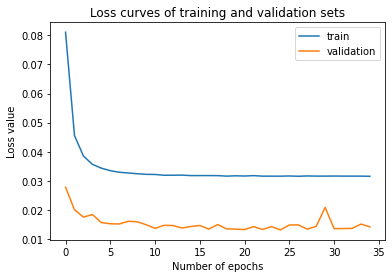

In [ ]:
plt.plot(Best_BiGRU_history.history['loss'], label='train')
plt.plot(Best_BiGRU_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Evaluating time taken for training by the best model.

In [ ]:
BiGRU_training_time = BiGRU_end_time - BiGRU_start_time
BiGRU_training_time

879.0579459667206

In [ ]:
y_pred_bigru = Best_BiGRU_model.predict(X_test)

In [ ]:
y_pred_bigru_inv = prediction_invertor(y_pred_bigru)

In [ ]:
rmse_bigru = metrics.mean_squared_error(y_test_inv, y_pred_bigru_inv, squared=False)
print('Test RMSE: %.3f' % rmse_bigru)

Test RMSE: 24.601


Evaluating the best model in terms of Mean Absolute Error.

In [ ]:
mae_bigru = metrics.mean_absolute_error(y_test_inv, y_pred_bigru_inv)
print('Test MAE: %.3f' % mae_bigru)

Test MAE: 14.548


Evaluating the best model in terms of R2 (R square) score.

In [ ]:
r2_bigru = metrics.r2_score(y_test_inv, y_pred_bigru_inv)
print('Test R2: %.3f' % r2_bigru)

Test R2: 0.930


Creating metric object of permetric library that would produce different evaluation metrics.

In [ ]:
evaluator0 = RegressionMetric(y_test_inv, y_pred_bigru_inv, decimal=3)

Evaluating the best model in terms of Nash-Sutcliffe Efficiency Coefficient.

In [ ]:
print('Test NSE: %.3f' % evaluator0.NSE())

Test NSE: 0.930


Evaluating the best model in terms of Coefficient of Determination.

In [ ]:
print('Test CC: %.3f' % evaluator0.coefficient_of_determination())

Test CC: 0.930


*Coding reference for above executions:*

https://scikit-learn.org/stable/modules/model_evaluation.html

https://pypi.org/project/permetrics/

Saving best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [ ]:
# tf.keras.models.save_model(Best_BiGRU_model, os.path.join(DATA_PATH,'Saved_Models/BiGRU'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Creating list of other cities in the study, the data of which will be used to train and test the best model, with transfer learning as well as without transfer learning.

In [13]:
other_cities_list = ['Bengaluru', 'Hyderabad', 'Jaipur', 'Mumbai']

Load data preprocessed data set of air pollution and meteorological data for other cities into a pandas dataframes.

In [14]:
for city in other_cities_list:
  globals()[f"{city}_air_met_df"] = pd.read_csv(os.path.join(DATA_PATH,'{}_air_met_df.csv'.format(city)))

Randomly checking if the datarames are created.

In [15]:
Hyderabad_air_met_df.head()

,Unnamed: 0,Datetime,sunHour,uvIndex.1,DewPointC,HeatIndexC,cloudcover,humidity,precipMM,pressure,...,windspeedKmph,CO,NH3,NO,NO2,NOx,O3,PM10,PM2.5,SO2
0,0,2015-01-04 14:00:00,8.7,7,15,27,40,48,0.0,1013,...,13,0.24,39.02,6.10,6.34,12.44,38.17,178.41,114.18,2.96
1,1,2015-01-04 15:00:00,8.7,7,15,26,45,50,0.0,1013,...,14,0.19,36.95,2.97,5.99,8.96,38.36,191.44,122.52,1.88
2,2,2015-01-04 16:00:00,8.7,6,15,26,43,53,0.0,1013,...,14,0.17,31.50,3.26,6.27,9.53,37.33,193.73,123.99,1.90
3,3,2015-01-04 17:00:00,8.7,6,15,25,41,57,0.0,1014,...,13,0.17,44.71,3.13,6.81,9.94,38.07,191.90,122.82,1.84
4,4,2015-01-04 18:00:00,8.7,6,15,25,38,60,0.0,1015,...,13,0.25,315.00,3.14,12.47,15.61,37.38,212.79,136.19,1.61


Loading best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [ ]:
Best_BiGRU_model_saved = tf.keras.models.load_model(os.path.join(DATA_PATH,'Saved_Models/BiGRU'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Defining a function that woudl do all the time series data preparation, training (excluding hyperparmeter tuning), testing and evaluation of best model for other cities, all in one go.

In [16]:
def model_run(df, time_lags, saved_model, city_name):
  print('The Best model is now being checked for {} city...'.format(city_name))
  df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

  tr_size = int(len(df) * 0.8)
  te_size = len(df) - tr_size
  tr_df, te_df = df.iloc[0:tr_size], df.iloc[tr_size:len(df)]

  scaler_func = MinMaxScaler(feature_range=(0,1))
  tr_df = pd.DataFrame(scaler_func.fit_transform(tr_df), columns=tr_df.columns)
  te_df = pd.DataFrame(scaler_func.transform(te_df), columns=te_df.columns)

  X_tr, y_tr = create_dataset(tr_df, tr_df['PM2.5'], time_lags)
  X_te, y_te = create_dataset(te_df, te_df['PM2.5'], time_lags)

  start_time = time.time()
  history = saved_model.fit(X_tr, y_tr, epochs=100, batch_size=32, validation_split=0.125, callbacks=[early_stopping_monitor])
  end_time = time.time()

  training_time = end_time - start_time
  print('Time taken for training the model is {} seconds.'.format(training_time))

  y_predicted = saved_model.predict(X_te)
  y_predicted_inverse = np.concatenate((te_df.values[:-24,:-1], y_predicted), axis=1)
  y_predicted_inverse = scaler_func.inverse_transform(y_predicted_inverse)[:,-1]

  y_te_reshaped = y_te.reshape(-1,1)
  y_te_inverse = np.concatenate((te_df.values[:-24,:-1], y_te_reshaped), axis=1)
  y_te_inverse = scaler_func.inverse_transform(y_te_inverse)[:,-1]

  print('The evaluation metrics for {} city are as follows:'.format(city_name))
  rmse_func = metrics.mean_squared_error(y_te_inverse, y_predicted_inverse, squared=False)
  print('Test RMSE: %.3f' % rmse_func)

  mae_func = metrics.mean_absolute_error(y_te_inverse, y_predicted_inverse)
  print('Test MAE: %.3f' % mae_func)

  r2_func = metrics.r2_score(y_te_inverse, y_predicted_inverse)
  print('Test R2: %.3f' % r2_func)

  evaluator_func = RegressionMetric(y_te_inverse, y_predicted_inverse, decimal=3)
  print('Test NSE: %.3f' % evaluator_func.NSE())
  print('Test CC: %.3f' % evaluator_func.coefficient_of_determination())

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  plt.title('Loss curves of training and validation sets')
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss value')
  plt.show()

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Bengaluru city...
Epoch 1/100
958/958 [==============================] - 29s 27ms/step - loss: 0.0352 - val_loss: 0.0173
Epoch 2/100
958/958 [==============================] - 26s 27ms/step - loss: 0.0324 - val_loss: 0.0160
Epoch 3/100
958/958 [==============================] - 28s 29ms/step - loss: 0.0315 - val_loss: 0.0158
Epoch 4/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0313 - val_loss: 0.0155
Epoch 5/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0312 - val_loss: 0.0156
Epoch 6/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0312 - val_loss: 0.0157
Epoch 7/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0310 - val_loss: 0.0164
Epoch 8/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0310 - val_loss: 0.0155
Epoch 9/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0311 - val_loss: 0.0160
Epoch 10/100
95

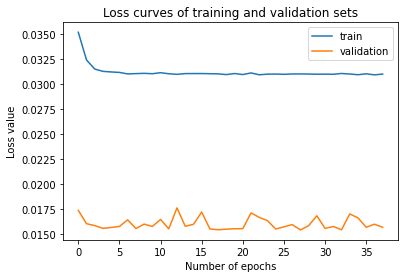

In [ ]:
model_run(Bengaluru_air_met_df,24,Best_BiGRU_model_saved,'Bengaluru')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [17]:
BLR_BiGRU_model = keras.Sequential()
BLR_BiGRU_model.add(layers.Bidirectional(layers.GRU(80, input_shape=(24, 21))))
BLR_BiGRU_model.add(layers.Dropout(0.2))
BLR_BiGRU_model.add(layers.Dense(1))
BLR_BiGRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

The Best model is now being checked for Bengaluru city...
Epoch 1/100
958/958 [==============================] - 26s 22ms/step - loss: 0.0803 - val_loss: 0.0198
Epoch 2/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0441 - val_loss: 0.0179
Epoch 3/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0374 - val_loss: 0.0164
Epoch 4/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0346 - val_loss: 0.0160
Epoch 5/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0332 - val_loss: 0.0156
Epoch 6/100
958/958 [==============================] - 21s 21ms/step - loss: 0.0324 - val_loss: 0.0156
Epoch 7/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0320 - val_loss: 0.0158
Epoch 8/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0318 - val_loss: 0.0163
Epoch 9/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0316 - val_loss: 0.0154
Epoch 10/100
95

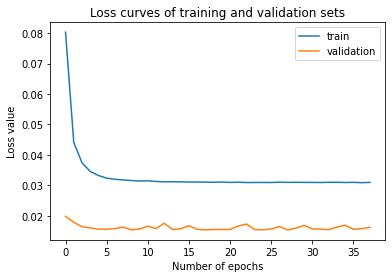

In [18]:
model_run(Bengaluru_air_met_df,24,BLR_BiGRU_model,'Bengaluru')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Hyderabad city...
Epoch 1/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0267 - val_loss: 0.0070
Epoch 2/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0263 - val_loss: 0.0073
Epoch 3/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0262 - val_loss: 0.0089
Epoch 4/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0260 - val_loss: 0.0073
Epoch 5/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0261 - val_loss: 0.0067
Epoch 6/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0260 - val_loss: 0.0068
Epoch 7/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0260 - val_loss: 0.0066
Epoch 8/100
957/957 [==============================] - 25s 26ms/step - loss: 0.0260 - val_loss: 0.0069
Epoch 9/100
957/957 [==============================] - 24s 26ms/step - loss: 0.0260 - val_loss: 0.0070
Epoch 10/100
95

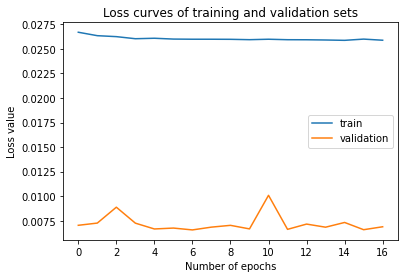

In [ ]:
model_run(Hyderabad_air_met_df,24,Best_BiGRU_model_saved,'Hyderabad')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [19]:
HYD_BiGRU_model = keras.Sequential()
HYD_BiGRU_model.add(layers.Bidirectional(layers.GRU(80, input_shape=(24, 21))))
HYD_BiGRU_model.add(layers.Dropout(0.2))
HYD_BiGRU_model.add(layers.Dense(1))
HYD_BiGRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

The Best model is now being checked for Hyderabad city...
Epoch 1/100
957/957 [==============================] - 25s 22ms/step - loss: 0.0872 - val_loss: 0.0127
Epoch 2/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0443 - val_loss: 0.0111
Epoch 3/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0352 - val_loss: 0.0109
Epoch 4/100
957/957 [==============================] - 21s 22ms/step - loss: 0.0315 - val_loss: 0.0103
Epoch 5/100
957/957 [==============================] - 21s 22ms/step - loss: 0.0297 - val_loss: 0.0082
Epoch 6/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0285 - val_loss: 0.0092
Epoch 7/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0278 - val_loss: 0.0081
Epoch 8/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0272 - val_loss: 0.0085
Epoch 9/100
957/957 [==============================] - 20s 21ms/step - loss: 0.0270 - val_loss: 0.0077
Epoch 10/100
95

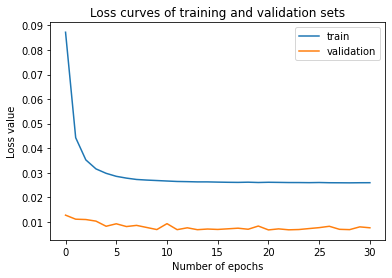

In [20]:
model_run(Hyderabad_air_met_df,24,HYD_BiGRU_model,'Hyderabad')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Jaipur city...
Epoch 1/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0205 - val_loss: 0.0113
Epoch 2/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0196 - val_loss: 0.0111
Epoch 3/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0192 - val_loss: 0.0107
Epoch 4/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0190 - val_loss: 0.0110
Epoch 5/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0188 - val_loss: 0.0115
Epoch 6/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0187 - val_loss: 0.0111
Epoch 7/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0186 - val_loss: 0.0115
Epoch 8/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0186 - val_loss: 0.0102
Epoch 9/100
488/488 [==============================] - 13s 26ms/step - loss: 0.0184 - val_loss: 0.0111
Epoch 10/100
488/4

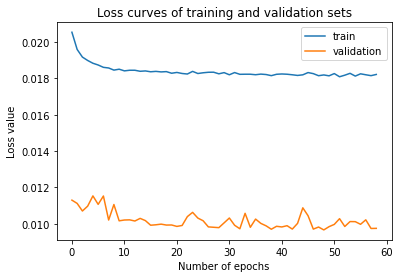

In [ ]:
model_run(Jaipur_air_met_df,24,Best_BiGRU_model_saved,'Jaipur')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [21]:
JPR_BiGRU_model = keras.Sequential()
JPR_BiGRU_model.add(layers.Bidirectional(layers.GRU(80, input_shape=(24, 21))))
JPR_BiGRU_model.add(layers.Dropout(0.2))
JPR_BiGRU_model.add(layers.Dense(1))
JPR_BiGRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

The Best model is now being checked for Jaipur city...
Epoch 1/100
488/488 [==============================] - 15s 24ms/step - loss: 0.0780 - val_loss: 0.0328
Epoch 2/100
488/488 [==============================] - 11s 22ms/step - loss: 0.0472 - val_loss: 0.0192
Epoch 3/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0366 - val_loss: 0.0158
Epoch 4/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0316 - val_loss: 0.0153
Epoch 5/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0282 - val_loss: 0.0133
Epoch 6/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0262 - val_loss: 0.0127
Epoch 7/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0247 - val_loss: 0.0126
Epoch 8/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0237 - val_loss: 0.0120
Epoch 9/100
488/488 [==============================] - 10s 21ms/step - loss: 0.0227 - val_loss: 0.0125
Epoch 10/100
488/4

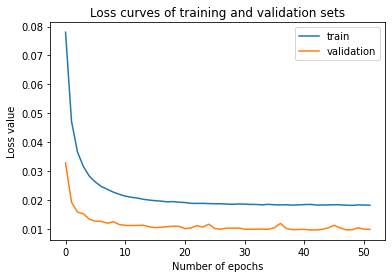

In [22]:
model_run(Jaipur_air_met_df,24,JPR_BiGRU_model,'Jaipur')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Mumbai city...
Epoch 1/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0516 - val_loss: 0.0207
Epoch 2/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0506 - val_loss: 0.0205
Epoch 3/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0506 - val_loss: 0.0179
Epoch 4/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0505 - val_loss: 0.0182
Epoch 5/100
958/958 [==============================] - 24s 26ms/step - loss: 0.0504 - val_loss: 0.0161
Epoch 6/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0505 - val_loss: 0.0172
Epoch 7/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0505 - val_loss: 0.0174
Epoch 8/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0505 - val_loss: 0.0163
Epoch 9/100
958/958 [==============================] - 24s 25ms/step - loss: 0.0504 - val_loss: 0.0178
Epoch 10/100
958/9

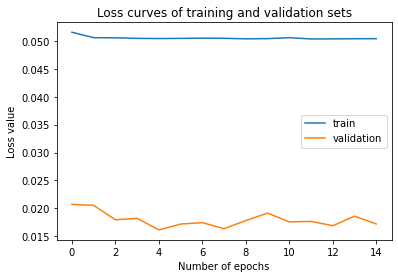

In [ ]:
model_run(Mumbai_air_met_df,24,Best_BiGRU_model_saved,'Mumbai')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [23]:
BOM_BiGRU_model = keras.Sequential()
BOM_BiGRU_model.add(layers.Bidirectional(layers.GRU(80, input_shape=(24, 21))))
BOM_BiGRU_model.add(layers.Dropout(0.2))
BOM_BiGRU_model.add(layers.Dense(1))
BOM_BiGRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.0001))

The Best model is now being checked for Mumbai city...
Epoch 1/100
958/958 [==============================] - 25s 22ms/step - loss: 0.0890 - val_loss: 0.0307
Epoch 2/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0612 - val_loss: 0.0275
Epoch 3/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0554 - val_loss: 0.0220
Epoch 4/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0531 - val_loss: 0.0209
Epoch 5/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0520 - val_loss: 0.0181
Epoch 6/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0515 - val_loss: 0.0186
Epoch 7/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0511 - val_loss: 0.0192
Epoch 8/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0510 - val_loss: 0.0171
Epoch 9/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0508 - val_loss: 0.0187
Epoch 10/100
958/9

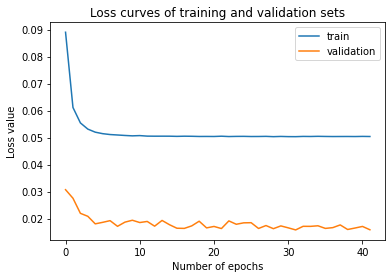

In [24]:
model_run(Mumbai_air_met_df,24,BOM_BiGRU_model,'Mumbai')